In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

In [7]:
digits = pd.read_csv('all/train.csv')

In [8]:
digits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [9]:
import math
digits = digits.iloc[0:math.floor(len(digits)*0.3),:]

In [11]:
X = digits.iloc[:,1:]
y = digits.iloc[:,0]
X_scaled = scale(X)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size=0.3, random_state=100)

In [15]:
lin_model = SVC(kernel='linear')
lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
print(metrics.accuracy_score(y_test,y_pred))

0.9105820105820106


In [14]:
model = SVC(kernel="rbf")
model.fit(X_train, y_train)
y_pred_rbf = model.predict(X_test)
print(metrics.accuracy_score(y_test,y_pred_rbf))

0.9314814814814815


In [17]:
p_model = SVC(kernel="poly")
p_model.fit(X_train, y_train)
y_pred_poly = p_model.predict(X_test)
print(metrics.accuracy_score(y_test,y_pred_poly))

0.8743386243386243


Since RBF does best lets do hyperparameter optimization

In [18]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                       n_jobs=4)      

# fit the model
model_cv.fit(X_train, y_train)                  


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 18.5min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 25.7min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

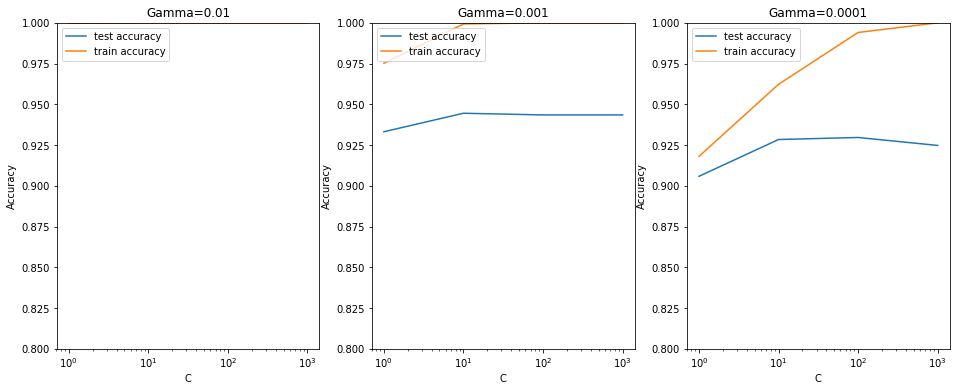

In [19]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)

# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [22]:
# specify optimal hyperparameters
best_params = {"C": 10, "gamma": 0.0001, "kernel":"rbf"}

# model
model = SVC(C=10, gamma=0.00005, kernel="rbf")

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# metrics
print(metrics.confusion_matrix(y_test, y_pred), "\n")
print("accuracy", metrics.accuracy_score(y_test, y_pred))
print("precision", metrics.precision_score(y_test, y_pred, average='weighted'))
print("sensitivity/recall", metrics.recall_score(y_test, y_pred, average='weighted'))

[[359   0   0   0   2   4   3   0   3   0]
 [  0 429   5   1   1   0   0   1   2   1]
 [  5   3 373   3   7   1   3   2   6   2]
 [  0   1  14 328   0   6   1   5  12   0]
 [  1   0   3   0 338   1   1   0   0  13]
 [  3   5   1  12   3 296   8   0   8   6]
 [  5   1   0   0   2   5 362   0   1   0]
 [  0   1   3   0   7   1   0 341   0  16]
 [  2   6   6   8   1  12   2   4 310   7]
 [  1   2   4   5  13   1   0  13   5 351]] 

accuracy 0.9224867724867725
precision 0.9222869654745199
sensitivity/recall 0.9224867724867725


In [24]:
test_digits = pd.read_csv('all/test.csv')

In [25]:
test_digits = scale(test_digits)

In [26]:
y_test_pred = model.predict(test_digits)

In [27]:
submission_df = pd.DataFrame(columns=['ImageId','Label'])

In [32]:
i = 0
for pred in y_test_pred:
    submission_df.loc[i,'ImageId'] = math.floor((i+1))
    submission_df.loc[i,'Label'] = math.floor(pred)
    i = i +1

In [33]:
submission_df.head()

,ImageId,Label
0,1.0,2.0
1,2.0,0.0
2,3.0,9.0
3,4.0,4.0
4,5.0,3.0


In [37]:
submission_df.ImageId = submission_df.ImageId.astype(int)
submission_df.Label = submission_df.Label.astype(int)

In [38]:
submission_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3


In [39]:
submission_df.to_csv('aryan_submission.csv', sep=',', index =False)